In [1]:
import pandas as pd
import seaborn as sns

In [2]:
pd.options.display.float_format = '{:.3f}'.format # not scientific

##### Question 1

In [3]:
tickers = ['GME','SPY']
stocks = []
for ticker in tickers:
    placeholder = ticker.lower()
    globals()[placeholder] = pd.read_csv(f'./{ticker}.csv')
    stocks.append(placeholder)
del placeholder

def add_true_label(stock_df):
    """arg --> stock DataFrame
    return --> stock DataFrame with + or - label column indicating positive
    or negative return for each day"""
    stock_df['True_Label'] = ['-' if r<0 else '+' for r in stock_df.Return]
    return stock_df

gme = add_true_label(gme)
spy = add_true_label(spy)

###### 2. take years 1,2 and 3. Let L be the number of trading days. Assuming 250 trading days per year, L will contain about 750 days. Let L− be all trading days with − labels and let L+ be all trading days with + labels. Assuming that all days are independent of each other and that the ratio of ”up” and ”down” days remains the same in the future, compute the default probability p ∗ that the next day is a ”up” day.

In [4]:
def default_p_123(stock_w_tl):
    """args --> take stock DataFrame with true labels
    return --> default probability of positive return"""
    s_123 = stock_w_tl.query('Year<2020').copy(deep=True)
    pos_123 = s_123.query('True_Label == "+"').shape[0]
    neg_123 = s_123.query('True_Label == "-"').shape[0]
    p_default = round(pos_123/(pos_123+neg_123),3)
    return p_default

In [5]:
p_default_gme = default_p_123(gme)
p_default_spy = default_p_123(spy)
(p_default_gme,p_default_spy)

(0.507, 0.569)

Q1 part 2 Answer = (0.507, 0.569) for gme, spy respectively

###### 3. take years 1, 2 and 3 What is the probability that after seeing k consecutive ”down days”, the next day is an ”up day”? For example, if k = 3, what is the probability of seeing ”−, −, −, +” as opposed to seeing ”−, −, −, −”. Compute this for k = 1, 2, 3.

In [6]:
def pattern_predict(stock, pattern):
    """args --> stock: DataFrame of stock data with the column True_Label. 
    pattern: csv string of True_Label values, 
    i.e. '+++' | '---' | '++-'| '+-'- | etc. 
    return --> p: probability of non-negative return"""
    pos_returns = 0
    sample_size = 0
    k = len(pattern)
    for i in range(k,len(stock)):
        if (''.join(stock.True_Label[(i-k):i]) == pattern):
            sample_size += 1
            if stock.True_Label[i] == '+':
                pos_returns += 1
    try:
        return (pos_returns/sample_size,sample_size)
    except ZeroDivisionError:
        return (p_default,0) # if there is no data, assume the default prob.

In [7]:
patterns = ['-','--','---']

neg_momentum_gme = [(len(pattern), round(pattern_predict(gme.query('Year<2020'),pattern)[0],3))
for pattern in patterns]

neg_momentum_spy = [(len(pattern), round(pattern_predict(spy.query('Year<2020'),pattern)[0],3))
for pattern in patterns]

print(neg_momentum_gme)
print(neg_momentum_spy)

[(1, 0.499), (2, 0.473), (3, 0.5)]
[(1, 0.563), (2, 0.592), (3, 0.586)]


Q1 part 3 answer: \
gme: [(1, 0.499), (2, 0.473), (3, 0.5)]\
spy: [(1, 0.563), (2, 0.592), (3, 0.586)]\
where i is number of prior consecutive negative days and j is the probability of a positive return on the following day in the above list of (i, j) tuples.

###### Q1 part 4 :  
4. take years 1, 2 and 3. What is the probability that after seeing k consecutive ”up days”, the next day is still an ”up day”? For example, if k = 3, what is the probability of seeing ”+, +, +, +” as opposed to seeing ”+, +, +, −”? Compute this for k = 1, 2, 3.

In [8]:
patterns = ['+','++','+++']

pos_momentum_gme = [(len(pattern), round(pattern_predict(gme.query('Year<2020'),pattern)[0],3))
for pattern in patterns]

pos_momentum_spy = [(len(pattern), round(pattern_predict(spy.query('Year<2020'),pattern)[0],3))
for pattern in patterns]

print(pos_momentum_gme)
print(pos_momentum_spy)

[(1, 0.513), (2, 0.51), (3, 0.51)]
[(1, 0.572), (2, 0.567), (3, 0.518)]


Q1 part 4 answer: \
gme: [(1, 0.513), (2, 0.51), (3, 0.51)]\
spy: [(1, 0.572), (2, 0.567), (3, 0.518)]\
Where i is number of prior consecutive positive days and j is the probability of a positive return on the following day in the above list of (i, j) tuples.

##### Question 2

Predicting labels: We will now describe a procedure to
predict labels for each day in years 4 and 5 from ”true” labels
in training years 1,2 and 3.
For each day d in year 4 and 5, we look at the pattern of
last W true labels (including this day d). By looking at the
frequency of this pattern and true label for the next day in the
training set, we will predict label for day d + 1. Here W is the
hyperparameter that we will choose based on our prediction
accuracy.
Suppose W = 3. You look at a partuclar day d and suppose
that the sequence of last W labels is s = ”−, +, −”. We want
to predict the label for next day d + 1. To do this, we count
the number of sequences of length W + 1 in the training set
where the first W labels coincide with s. In other words, we
count the number N−(s) of sequences ”s, −” and the number
of sequences N+(s) of sequences ”s, +”. If N+(s) ≥ N−(s)
then the next day is assigned ”+”. If N+(s) < N−(s) then the
next day is assigned ”−”. **In the unlikely event that N+(s) =
N−(s) = 0 we will assign a label based on default probability
p∗**
that we computed in the previous question.

###### Functions used to generate the probability of a positive return given a preceding pattern in daily return indicators

In [9]:
def hydra(patterns):
    """take a list of patterns and return a list with a '+' and '-' added to
    each pattern"""
    patterns_doubled = []
    for p in patterns:
        patterns_doubled.append(p+'+')
        patterns_doubled.append(p+'-')
    return patterns_doubled

def perm(w):
    """find all possible return label patterns/permutations of length w.  
    2**w patterns are possible"""
    p=['']
    while len(p) < 2**(w):
        p = hydra(p)
    return p

def perm_probs(stock,perm):
    """get the probability of a positive return for each permutation of 
    + and - """
    probs = {}
    for p in perm:
        probs[p] = pattern_predict(stock,p)
    return probs

###### Functions to generate labels for observations for different hyperparameters W in years 4 & 5

In [10]:
def update_perm_prob(pattern, pos, pat_prob_n):
    """updates the dictionary of {permutation: pos_return_prob}
    args: pattern,i.e. '+++' | pos: boolean True if positive return | 
    pat_prob_n: the dictionary being updated"""
    n = pat_prob_n[pattern][1]+1
    p0 = pat_prob_n[pattern][0]
    p1 = (p0*(n-1) + pos)/(n)
    pat_prob_n[pattern] = (p1,n)
    return pat_prob_n

def default_lab(p_default):
    if p_default>=.5:
        return '+'
    else:
        return '-'
    
def predict_45(stock,ws):
    """generate a DataFrame of true labels and predictions for a range of 
    hyperparameters for stock data in years 4 and 5"""
    
    stock_45 = stock.query('Year>=2020').copy(deep=True) # New data
    stock_123 = stock.query('Year<2020').copy(deep=True) # Train data
    labels_45 = stock_45['True_Label'].copy(deep=True).to_frame()

    # after first trading day is seen, can use lead up pattern in subsequent
    # predictions.
    max_w = ws[-1]
    stock_45 = pd.concat([stock_123[-max_w:],stock_45],axis=0) 
    pat_prob_n = {} # initialize
    for w in ws:  # iterate through hyperparameters
        
        preds = []
        pat_prob_n.update(perm_probs(stock_123,perm(w)))
        
        # iterate, considering that eoy3 data is prepended
        
        for i in range(max_w,len(stock_45)):
            pattern = ''.join(stock_45.True_Label[i-w:i])
            prob = pat_prob_n[pattern][0]
            
            try:
                if prob>.5:
                    pos = 1
                    preds.append('+')
                elif prob<.5:
                    pos = 0
                    preds.append('-')
                else:
                    p_default = default_p_123(stock_123)
                    pos = [1 if (p > .5) else 0 for p in [p_default]][0]
                    preds.append(default_lab(p_default))
                    
            except TypeError: # in case pattern never before seen
                preds.append(defualt_lab(p_default))
            # update dictionary with latest datapoint.
            pat_prob_n = update_perm_prob(pattern,pos,pat_prob_n)
            
        labels_45[f'w_{w}'] = preds
    return labels_45 

###### Q2 part 1
For W = 2, 3, 4, compute predicted labels for each day in
year 4 and 5 based on true labels in years 1,2 and 3 only.
Perform this for your ticker and for ”spy”.  Note:  I used all prior data for predicting labels in years 4 & 5

In [11]:
w_labs_gme = predict_45(gme,[2,3,4])
w_labs_spy = predict_45(spy,[2,3,4])

###### Q2 part 2
For each W = 2, 3, 4, compute the accuracy - what percentage of true labels (both positive and negative) have you predicted correctly for the last two years.

In [12]:
def accuracy(labels_predictions):
    """args --> take a DataFrame of true return labels and hyperparam W 
    predicted labels
    return --> a dictionary of accuracies for each hyperparameter"""    
    n = labels_predictions.shape[0]
    # generate dictionary entry of accuracy for each hyperparameter
    acc_df = pd.DataFrame({h: sum(labels_predictions[h]==
           labels_predictions.iloc[:,0])/n for h in labels_predictions},
                        index = ["Accuracy"])
    return acc_df

Q2 part 2 answer -- SPY

In [13]:
accuracy(w_labs_spy)

,True_Label,w_2,w_3,w_4
Accuracy,1.000,0.579,0.579,0.540


Q2 part 2 answer -- GME

In [14]:
accuracy(w_labs_gme)

,True_Label,w_2,w_3,w_4
Accuracy,1.000,0.478,0.504,0.488


###### Q2 Part 3
Which W∗ value gave you the highest accuracy for your
stock and and which W∗ value gave you the highest accuracy
for S&P-500?

Q2_3_GME: a W of 3 gave the highest accuracy of 0.502
Q2_3_SPY: W's of 2 and 3 each gave accuracy of 0.579

##### Question 3. 
One of the most powerful methods to (potentially) improve predictions is to combine predictions by some
”averaging”. This is called ensemble learning. Let us consider
the following procedure: for every day d, you have 3 predicted
labels: for W = 2, W = 3 and W = 4. Let us compute an
”ensemble” label for day d by taking the majority of your labels for that day. For example, if your predicted labels were
”−”,”−” and ”+”, then we would take ”−” as ensemble label
for day d (the majority of three labels is ”−”). If, on the other
hand, your predicted labels were ”−”, ”+” and ”+” then we
would take ”+” as ensemble label for day d (the majority of
predicted labels is ”+”). Compute such ensemble labels and
answer the following:
1. compute ensemble labels for year 4 and 5 for both your
stock and S&P-500.
2. for both S&P-500 and your ticker, what percentage of labels
in year 4 and 5 do you compute correctly by using ensemble?
3. did you improve your accuracy on predicting ”−” labels by
using ensemble compared to W = 2, 3, 4?
4. did you improve your accuracy on predicting ”+” labels by
using ensemble compared to W = 2, 3, 4?

###### Q3 Part 1 | compute ensemble labels for year 4 and 5 for both your stock and S&P-500.

In [15]:
def majority_predict(labels_df):
    """take a DataFrame of labels and return the same dataframe with an extra
    column indicating the 'ensemble' prediction"""
    
    labels_df['e'] = labels_df.filter(regex='w_').mode(axis=1)
    return labels_df

In [16]:
w_e_labs_gme = majority_predict(w_labs_gme.copy(deep=True))
w_e_labs_spy = majority_predict(w_labs_spy.copy(deep=True))

###### Q3 Part 2 | for both S&P-500 and your ticker, what percentage of labels in year 4 and 5 do you compute correctly by using ensemble?

GME: 48.2% accuracy

In [17]:
accuracy(w_e_labs_gme)

,True_Label,w_2,w_3,w_4,e
Accuracy,1.000,0.478,0.504,0.488,0.482


SPY: 57.9% accuracy

In [18]:
accuracy(w_e_labs_spy)

,True_Label,w_2,w_3,w_4,e
Accuracy,1.000,0.579,0.579,0.540,0.579


###### Q3 Part 3 | did you improve your accuracy on predicting ”−” labels by using ensemble compared to W = 2, 3, 4?

In [19]:
def accuracy_specific(labels_predictions,lab):
    """args -->  
    labels_predictions: a DataFrame of true return labels and hyperparam W 
    predicted labels
    lab: "+" or "-"
    return --> a dictionary of accuracies for each hyperparameter"""
    labels_predictions = labels_predictions.query(f'True_Label == "{lab}"')
    n = labels_predictions.shape[0]
    # generate dictionary entry of accuracy for each hyperparameter
    acc_df = pd.DataFrame({h: sum(labels_predictions[h]==
           labels_predictions.iloc[:,0])/n for h in labels_predictions},
                        index = ["Accuracy"])
    return acc_df

In [20]:
accuracy_specific(w_e_labs_spy,'-')

,True_Label,w_2,w_3,w_4,e
Accuracy,1.000,0.000,0.000,0.179,0.000


In [21]:
accuracy_specific(w_e_labs_gme,'-')

,True_Label,w_2,w_3,w_4,e
Accuracy,1.000,0.243,0.378,0.293,0.363


For SPY, ensemble accuracy was 0.00% along with w_2 and w_3, while w_4 scored 17.9% accuracy\
For GME, ensemble accuracy (36.3%) was better than w_3 (37.8) and w_4 (29.3%) but worse than w_2.

###### Q3 Part 4 | did you improve your accuracy on predicting ”+” labels by using ensemble compared to W = 2, 3, 4?

In [22]:
accuracy_specific(w_e_labs_spy,'+')

,True_Label,w_2,w_3,w_4,e
Accuracy,1.000,1.000,1.000,0.801,1.000


In [23]:
accuracy_specific(w_e_labs_gme,'+')

,True_Label,w_2,w_3,w_4,e
Accuracy,1.000,0.727,0.637,0.694,0.608


GME: ensemble accuracy (60.8%) was worse than each model alone.

SPY: ensemble accuracy (100%) was better than w_4 (80.1%) but same as w_2 (100%) & w_4 (100%)

##### Question 4: For W = 2, 3, 4 and ensemble, compute the following (both for your ticker and ”spy”) statistics based on years 4 and 5:
1. TP - true positives (your predicted label is + and true label
is +
2. FP - false positives (your predicted label is + but true label
is −
3. TN - true negativess (your predicted label is − and true
label is −
4. FN - false negatives (your predicted label is − but true label
is +
5. TPR = TP/(TP + FN) - true positive rate. This is the fraction of positive labels that your predicted correctly. This is
also called sensitivity, recall or hit rate.
6. TNR = TN/(TN + FP) - true negative rate. This is the
fraction of negative labels that your predicted correctly.
This is also called specificity or selectivity
7. summarize your findings in the table as shown below:


<img src="table_3.png"  alt="table_3" width="325"/>

8. discuss your findings


In [24]:
w_e_labs_gme.name="GME"

In [25]:
w_e_labs_spy.name="SPY"

In [26]:
def true_positives(labels_frames):
    stats = pd.DataFrame()
    for labels in labels_frames:
        n = labels.shape[0]
        hps = labels.filter(regex="(w_)|e$").columns # hyperparameters 
        pos_inx = labels[labels.True_Label=='+'].index
        neg_inx = labels[labels.True_Label=='-'].index
        tp = [sum(labels.True_Label[pos_inx] == labels[hp][pos_inx]) 
              for hp in hps]
        fp = [sum(labels.True_Label[pos_inx] != labels[hp][pos_inx]) 
              for hp in hps]
        tn = [sum(labels.True_Label[neg_inx] == labels[hp][neg_inx]) 
              for hp in hps]
        fn = [sum(labels.True_Label[neg_inx] != labels[hp][neg_inx]) 
              for hp in hps]
        a = ["{:.1%}".format(round(sum(labels.True_Label == labels[hp])/n,3)) for hp in hps]
        tpr = [round(element/len(pos_inx),3) for element in tp]
        tnr = [round(element/len(neg_inx),3) for element in tn]
        hi = pd.MultiIndex.from_arrays([[hp[-1] for hp in hps],
                                        [labels.name]*len(hps)])
        stats = pd.concat([stats,pd.DataFrame({'TP':tp,'FP':fp,'TN':tn,
                        'FN':fn,'Accuracy':a,'TPR':tpr,'TNR':tnr},index = hi)])
    return stats

In [27]:
true_positives([w_e_labs_spy,w_e_labs_gme])

,,TP,FP,TN,FN,Accuracy,TPR,TNR
2,SPY,292,0,0,212,57.9%,1.000,0.000
3,SPY,292,0,0,212,57.9%,1.000,0.000
4,SPY,234,58,38,174,54.0%,0.801,0.179
e,SPY,292,0,0,212,57.9%,1.000,0.000
2,GME,178,67,63,196,47.8%,0.727,0.243
3,GME,156,89,98,161,50.4%,0.637,0.378
4,GME,170,75,76,183,48.8%,0.694,0.293
e,GME,149,96,94,165,48.2%,0.608,0.363


<img src="roc_stats.png"  alt="roc_stats" width="325"/>
From the statistics above, we can see that for the s&p 500 there are only positive predictions for hyperparams of 2,3, and ensemble while a W of 4 at least makes an attempt at negative predictions, so that some of the length 4 permulations of '+' and '-' are associated with negative returns more than 50% of the time.  This seems to match the generally consistent upward trend (and more often than not positive returns) over the five years of the S&P 500 data examined.  For GME, the higher number of negative predictions, and hence slightly more acceptable **TNR** indicates that returns following a pattern were less universally positive on average.  The surprising fact that the accuracy was under 50% for GME for hyperparams of W=2,3, and ensemble indicate that the overall trend in the returns shifted from years 1,2 & 3 to years 4 & 5. In otherwords, either a stable trend became more definitively positive or negative or there was a directional switch.
\
Most accurate, arguably "best" values of hyperparams for SPY & GME:
SPY: 2,3 and Ensemble are the most accurate
GME: a W of 3 leads to the greatest accuracy.

##### Question 5: At the beginning of year 4 you start with $100 dollars and trade for 2 years based on predicted labels.
1. take your stock. Plot the growth of your amount for 2 years
if you trade based on best W∗
and on ensemble. On the
same graph, plot the growth of your portfolio for ”buy-andhold” strategy
2. examine your chart. Any patterns? (e.g any differences in
year 4 and year 5)

###### Q5 Part 1: take your stock. Plot the growth of your amount for 2 years if you trade based on best W∗ and on ensemble. On the same graph, plot the growth of your portfolio for ”buy-andhold” strategy

In [28]:
def cumulative_returns(r,begin_amt):
    c_r = [1+r.pop(0)]
    while r:
        c_r.append(c_r[-1]*(1+r.pop(0)))
    return [begin_amt*cr for cr in c_r]

In [29]:
def returns_to_date(labels):
    with_returns = pd.concat([labels,globals()[labels.name.lower()].\
               query('Year >= 2020').Return],axis=1)
    hps = with_returns.filter(regex='(w_)|(e$)').columns
    c_r_df = pd.DataFrame()
    for hp in hps:
        return_col_name = f'{hp}_return'
        returns_list = [r if lab == '+' else 0 for lab,r in zip(
            with_returns[hp],with_returns.Return) ]
        cr = cumulative_returns(returns_list,100)
        c_r_df = pd.concat([c_r_df,pd.Series(cr,name = return_col_name)],axis=1)
    b_and_h = cumulative_returns([r for r in with_returns.Return],100)
    c_r_df = pd.concat([c_r_df,pd.Series(b_and_h,name = 'buy_and_hold')],axis=1)
    return c_r_df

In [30]:
spy_returns = returns_to_date(w_e_labs_spy)
spy_returns.name='spy_returns'
spy_returns

,w_2_return,w_3_return,w_4_return,e_return,buy_and_hold
0,100.935,100.935,100.935,100.935,100.935
1,100.171,100.171,100.171,100.171,100.171
2,100.553,100.553,100.171,100.553,100.553
3,100.270,100.270,99.889,100.270,100.270
4,100.805,100.805,100.422,100.805,100.805
...,...,...,...,...,...
499,150.928,150.928,122.854,150.928,150.928
500,153.064,153.064,122.854,153.064,153.064
501,152.939,152.939,122.754,152.939,152.939
502,153.135,153.135,122.911,153.135,153.135


In [31]:
gme_returns = returns_to_date(w_e_labs_gme)
gme_returns.name='gme_returns'
gme_returns

,w_2_return,w_3_return,w_4_return,e_return,buy_and_hold
0,103.783,100.000,100.000,100.000,103.783
1,96.711,100.000,93.185,93.185,96.711
2,96.217,99.490,92.710,92.710,96.217
3,96.217,99.490,87.480,92.710,90.789
4,96.217,103.094,87.480,92.710,94.079
...,...,...,...,...,...
499,2063.587,542.914,315.918,281.504,2502.303
500,2063.587,542.914,315.918,281.504,2439.309
501,2063.587,536.142,315.918,281.504,2408.882
502,2063.587,563.487,332.031,295.862,2531.743


Most accurate, arguably "best" values of hyperparams for SPY & GME:
SPY: 2,3 and Ensemble are the most accurate
GME: a W of 3 leads to the greatest accuracy.

From the tables above, trading based on the most accurate hyperparameters does not necessarily lead to the best cumulative returns over years 4 & 5.  

For SPY, the 'time in the market' strategy does in fact generate better returns than the other strategies tested.

For GME, staying out of the market on days predicted to be negative by the W=2 strategy does worse than the buy & hold strategy, while following a trading strategy based on the most accurate hyperparameter does quite horribly in comparison to both the 'time in the market' and W_2 approaches, while returning slightly better than W_4.  Interestingly, the ensemble strategy does by far the worst! This could be because w_2, w_3, and w_4 tend to predict the same days as negative, so that if one predicts positive and the other two negative the ensemble will chose to stay out of the market, while one of the individual strategies stays in the market and earns a positive return.  The high variability in GME's returns could be due to the randomness inherent in extreme volatility, where a small number of key trades or non-trades can make all the difference.

From the tables above, trading based on the most accurate hyperparameters does not necessarily lead to the best cumulative returns over years 4 & 5.  

For SPY, the 'time in the market' strategy does in fact generate better returns than the other strategies tested.

For GME, staying out of the market on days predicted to be negative by the W=2 strategy does worse than the buy & hold strategy, while following a trading strategy based on the most accurate hyperparameter does quite horribly in comparison to both the 'time in the market' and W_2 approaches, while returning slightly better than W_4.  Interestingly, the ensemble strategy does by far the worst! This could be because w_2, w_3, and w_4 tend to predict the same days as negative, so that if one predicts positive and the other two negative the ensemble will chose to stay out of the market, while one of the individual strategies stays in the market and earns a positive return.  The high variability in GME's returns could be due to the randomness inherent in extreme volatility, where a small number of key trades or non-trades can make all the difference.

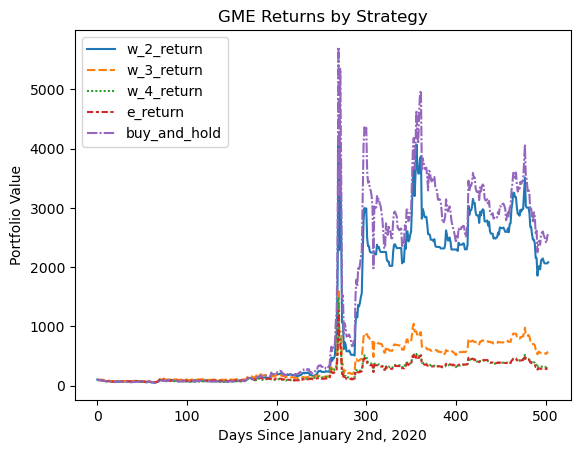

In [32]:
gme_plot = (sns.lineplot(data=gme_returns))
gme_plot.set(xlabel='Days Since January 2nd, 2020', ylabel='Portfolio Value',
            title='GME Returns by Strategy')
gme_plot;

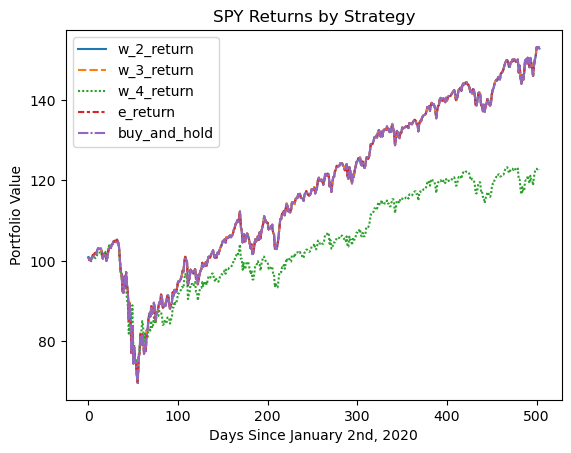

In [33]:
spy_plot = (sns.lineplot(data=spy_returns))
spy_plot.set(xlabel='Days Since January 2nd, 2020', ylabel='Portfolio Value',
            title='SPY Returns by Strategy')
spy_plot;

###### Q5 Part 2. examine your chart. Any patterns? (e.g any differences in year 4 and year 5)

After examining the charts, the analysis resulting from looking at the tables largely hold.  The immense returns and losses around the 280 day mark for GME as well as high subsequent volatility supports the notion that missing out on a few trading days can have a massively negative impact on one's portfolio.  Similarly, for SPY, if one missed out on a few trading days because one's model decided to stay out of the market, the overall return was significantly worse.  Notably, there appeared to be little protection from the pandemic-induced bear market of early 2020 by following the W=4 strategy and choosing not to trade some days.